# Prueba A/B tienda en linea

### 1.Explora los datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Cargamos datos

In [2]:
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')
marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')

In [3]:
# primera filas de vents
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [4]:
# primeras filas de new_users
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [5]:
# primeras filas de participants
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [6]:
# primeras filas de marketing
marketing.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [7]:
# informacion general de datasets events
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [8]:
# informacion general de datasets new_users
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [9]:
# informacion general de datasets participants
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [10]:
# informacion general de datasets marketing
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [11]:
# solo en el df events hay valores nulos
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

In [12]:
purchase_data = events[events['event_name'] == 'purchase'].copy()
purchase_data['details'] = purchase_data['details'].astype(float)

In [13]:
# convertimos las columnas que contienen fechas a tipo datetime
events['event_dt'] = pd.to_datetime(events['event_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])

### 2. análisis exploratorio de datos.

*  conversión en las diferentes etapas del embudo.

In [14]:
# Unino los eventos con la info de grupo
events = events.merge(participants, on='user_id')
events

,user_id,event_dt,event_name,details,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,B,interface_eu_test
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,B,interface_eu_test
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,B,interface_eu_test
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,B,interface_eu_test
...,...,...,...,...,...,...
102833,40076B77CFC12421,2020-12-23 03:43:28,login,NaN,B,interface_eu_test
102834,40076B77CFC12421,2020-12-24 04:21:53,login,NaN,B,interface_eu_test
102835,40076B77CFC12421,2020-12-26 03:50:17,login,NaN,B,interface_eu_test
102836,301C602AF78BABAD,2020-12-23 10:39:25,login,NaN,B,interface_eu_test


In [15]:
# Filtro eventos clave
funnel_events = ['product_page', 'product_cart', 'purchase']
funnel_data = events[events['event_name'].isin(funnel_events)]

In [16]:
# cuento cuántos usuarios únicos hicieron cada evento por grupo
funnel_data = funnel_data.merge(participants, on='user_id', how='left')

In [17]:
funnel_data.columns

Index(['user_id', 'event_dt', 'event_name', 'details', 'group_x', 'ab_test_x',
       'group_y', 'ab_test_y'],
      dtype='object')

In [18]:
funnel_data = funnel_data.rename(columns={'group_x': 'group'})
funnel_data.columns

Index(['user_id', 'event_dt', 'event_name', 'details', 'group', 'ab_test_x',
       'group_y', 'ab_test_y'],
      dtype='object')

In [19]:
print(funnel_data['group'].isna().sum())

0


In [20]:
funnel_summary = funnel_data.pivot_table(index='group',
                                         columns='event_name',
                                         values='user_id',
                                         aggfunc='nunique').reset_index()

In [21]:
users_per_group = participants.groupby('group')['user_id'].nunique()
funnel_summary['total_users'] = funnel_summary['group'].map(users_per_group)


In [22]:
print(funnel_summary.columns)

Index(['group', 'product_cart', 'product_page', 'purchase', 'total_users'], dtype='object', name='event_name')


In [23]:
# Tasa de convercion por etapas
funnel_summary['view_to_cart'] = funnel_summary['product_cart'] / funnel_summary['product_page']
funnel_summary['cart_to_purchase'] = funnel_summary['purchase'] / funnel_summary['product_cart']
funnel_summary['view_to_purchase'] = funnel_summary['purchase'] / funnel_summary['product_page']


In [24]:
conversion_summary = funnel_summary[['group', 'view_to_cart', 'cart_to_purchase', 'view_to_purchase']]
conversion_summary

event_name,group,view_to_cart,cart_to_purchase,view_to_purchase
0,A,0.476767,1.080145,0.514977
1,B,0.511039,0.985763,0.503763


Aunque el grupo B muestra una pequeña mejora en la primera etapa del embudo (view_to_cart), esto no se traduce en un aumento general de compras, y de hecho, sufre una ligera caída en la etapa de cart_to_purchase. 

**¿El número de eventos por usuario está distribuido equitativamente entre las muestras?**

In [25]:
event_counts = events.groupby('user_id').size().reset_index(name='event_count')
event_counts = event_counts.merge(participants, on='user_id')

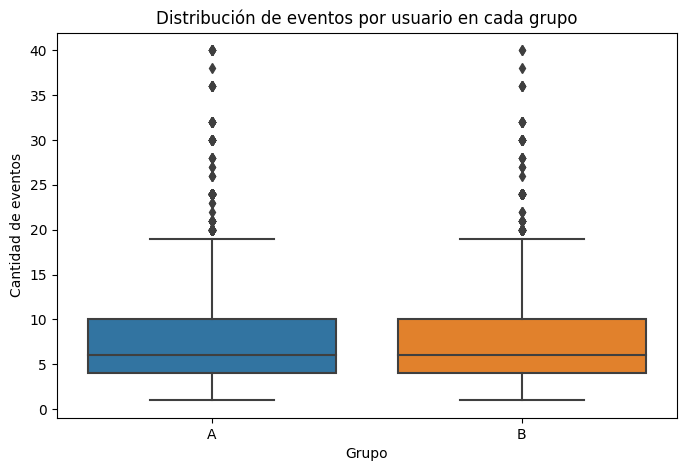

In [26]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=event_counts, x='group', y='event_count')
plt.title('Distribución de eventos por usuario en cada grupo')
plt.ylabel('Cantidad de eventos')
plt.xlabel('Grupo')
plt.show()

Ambos grupos (A y B) presentan una distribución muy similar en la cantidad de eventos por usuario. La mediana está cerca de 7-8 eventos por usuario.

**¿Hay usuarios que están presentes en ambas muestras?**

In [27]:
users_A = participants[participants['group'] == 'A']['user_id']
users_B = participants[participants['group'] == 'B']['user_id']
duplicated_users = set(users_A).intersection(set(users_B))
print(f"Cantidad de usuarios en ambos grupos: {len(duplicated_users)}")

Cantidad de usuarios en ambos grupos: 441


**¿Cómo se distribuye el número de eventos entre los días?**

In [28]:
# Agrupamos por fecha y contar eventos
events_by_day = events.groupby(events['event_dt'].dt.date).size()

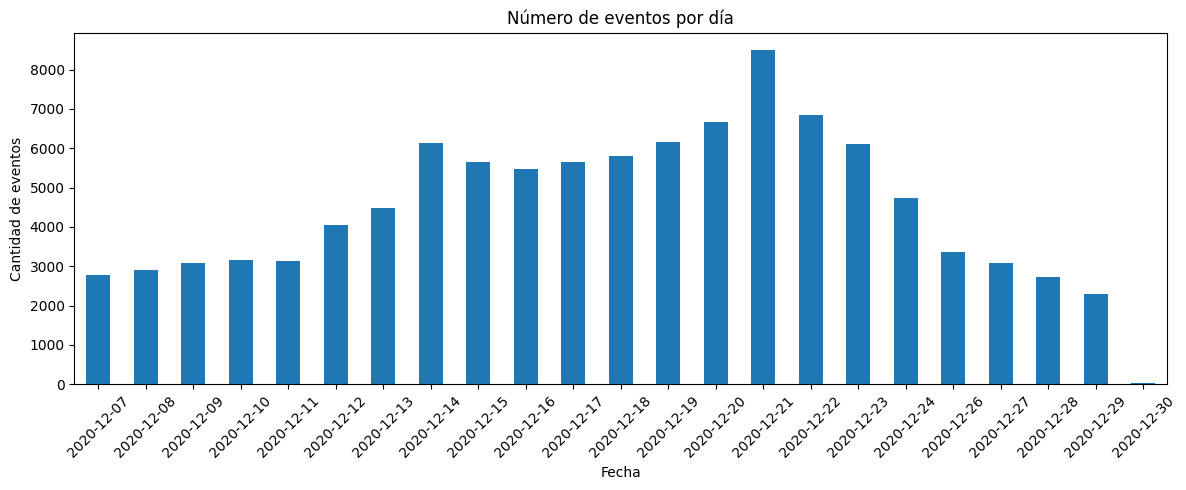

In [29]:
plt.figure(figsize=(12, 5))
events_by_day.plot(kind='bar')
plt.title('Número de eventos por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Tendencia creciente: Desde el 7 hasta el 21 de diciembre de 2020 (fecha límite para la incorporación de nuevos usuarios), se observa un incremento sostenido en el número de eventos. Esto sugiere que la llegada progresiva de nuevos usuarios generó una mayor actividad en la plataforma.

* Pico máximo: El 21 de diciembre, justo el último día de captación, se alcanzó el punto más alto de actividad con casi 10.000 eventos. Esto puede estar relacionado con una campaña de marketing o un empujón final de incorporación de usuarios.

* Tendencia decreciente: A partir del 22 de diciembre, la cantidad de eventos disminuye gradualmente. Esto es esperable ya que no se suman nuevos usuarios y posiblemente algunos ya completaron su ciclo de 14 días.

**¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?**

Sí, se identifican algunas particularidades importantes:

* Valores nulos: La columna details en el dataset de eventos tiene valores nulos, pero esto es esperable, ya que solo aplica a eventos de tipo purchase. No representa un problema si se filtran adecuadamente antes del análisis.

* Usuarios duplicados en grupos: Se verificó que no hay usuarios presentes en ambos grupos A y B, por lo que la asignación fue correcta.

* Distribución desigual de eventos por usuario: El gráfico de caja muestra una distribución con muchos valores atípicos, lo que sugiere que algunos usuarios realizaron una gran cantidad de eventos. Esto podría sesgar el análisis si no se trabaja con tasas (proporciones) en lugar de totales absolutos.

* Pico de actividad antes del cierre del experimento: El 21 de diciembre, día de cierre de la incorporación de usuarios, muestra un pico inusualmente alto de eventos. Esto puede influir en las tasas de conversión y debe ser considerado en el análisis.

* Duración del seguimiento: No todos los usuarios tienen el mismo número de días de observación, ya que se les sigue por 14 días desde su registro. Es clave asegurarse de que todos los usuarios analizados hayan completado este período.

### 3. Evaluar los resultados de la prueba A/B

In [30]:
from statsmodels.stats.proportion import proportions_ztest

def z_test(success_a, size_a, success_b, size_b):
    count = np.array([success_a, success_b])
    nobs = np.array([size_a, size_b])
    stat, pval = proportions_ztest(count, nobs)
    return stat, pval

In [31]:
group_a = funnel_summary[funnel_summary['group'] == 'A']
group_b = funnel_summary[funnel_summary['group'] == 'B']

n_a = int(group_a['total_users'])
n_b = int(group_b['total_users'])

**Prueba 1: product_page - product_cart**

In [32]:
success_a = int(group_a['product_cart'])
success_b = int(group_b['product_cart'])

stat, pval = z_test(success_a, n_a, success_b, n_b)
print(f"Z-test vista a carrito: z = {stat:.2f}, p = {pval:.4f}")

Z-test vista a carrito: z = -1.63, p = 0.1025


p = 0.10225  No hay evidencia estadística suficiente para afirmar que la conversión de vista a carrito difiere significativamente entre los grupos A y B.

**Prueba 2: product_cart - purchase**

In [33]:
if n_a > 0 and n_b > 0:
    stat, pval = z_test(success_a, n_a, success_b, n_b)
    print(f"Z-test carrito a compra: z = {stat:.2f}, p = {pval:.4f}")
else:
    print("No se puede aplicar la prueba Z: uno de los grupos no tiene datos suficientes para 'product_cart'")

Z-test carrito a compra: z = -1.63, p = 0.1025


No hay diferencia significativa en la conversión de carrito a compra entre los grupos.

**Prueba 3: product_page - purchase**

In [34]:
success_a = int(group_a['purchase'])
success_b = int(group_b['purchase'])

n_a = int(group_a['product_page'])
n_b = int(group_b['product_page'])

stat, pval = z_test(success_a, n_a, success_b, n_b)
print(f"Z-test vista a compra: z = {stat:.2f}, p = {pval:.4f}")

Z-test vista a compra: z = 1.07, p = 0.2865


p = 0.2865 Tampoco se observa una diferencia estadísticamente significativa en la conversión directa de vista a compra.

**Conclusión**
Ninguna de las tres etapas clave del embudo (vista → carrito, carrito → compra, vista → compra) mostró una mejora estadísticamente significativa en el grupo de prueba (grupo B) respecto al grupo de control (grupo A).
Esto sugiere que el nuevo sistema de recomendaciones no logró un aumento del 10% en la conversión como se esperaba.

**Conclusión General**

Tras realizar el análisis exploratorio de datos y evaluar los resultados de la prueba A/B, se concluye que el nuevo sistema de recomendaciones implementado en el grupo B no generó mejoras significativas en la conversión de los usuarios a lo largo del embudo (product_page → product_cart → purchase).
Las pruebas estadísticas no arrojaron diferencias significativas entre los grupos, por lo que no se justifica adoptar el nuevo sistema con base en los datos actuales. Se recomienda no implementar los cambios y considerar otras estrategias para mejorar la conversión, así como profundizar en el análisis del comportamiento del usuario para identificar oportunidades de optimización más efectivas.

In [1]:
print("final")

final
